In [20]:
import sklearn.preprocessing
import tensorboard
import tensorflow as tf
from packaging import version
from datetime import datetime
import numpy as np
from linkmethods import get_target, get_backlink_views
from keras.layers import *
import keras.backend

In [4]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.11.0


In [5]:
tensorboard.__version__

'2.11.0'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
article = "Meisen"

In [8]:
df_main = get_target(article)

Directory already exists, or the path is wrong


In [9]:
bl_views = get_backlink_views(article, get_target(article))

Directory already exists, or the path is wrong
            views
timestamp        
2015070100    2.0
2015070200    0.0
2015070300    4.0
2015070400    4.0
2015070500    1.0
...           ...
2022062700    1.0
2022062800    3.0
2022062900    1.0
2022063000    0.0
2022070100    3.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100    7.0
2015070200   10.0
2015070300    6.0
2015070400    7.0
2015070500   11.0
...           ...
2022062700    5.0
2022062800    9.0
2022062900   11.0
2022063000   14.0
2022070100    9.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100   1678
2015070200   1719
2015070300   1764
2015070400   1876
2015070500   2426
...           ...
2022062700   2452
2022062800   2906
2022062900   2974
2022063000   2838
2022070100   1921

[2558 rows x 1 columns]
            views
timestamp        
2015070100    0.0
2015070200    0.0
2015070300    0.0
2015070400    0.0
2015070500    0.0
...           ...
2022062700    0.0
2022062800    

In [11]:
roundoff = 10

In [12]:
roundeddata = []
for entry in bl_views:
    roundeddata.append((entry[:]//roundoff*roundoff)[-250:-1])
np.shape(roundeddata)

(162, 249)

In [13]:
roundeddata = np.array(roundeddata)

In [14]:
data = np.array(bl_views)[:,-250:-1]
print(data)
data.shape

[[0.000e+00 4.000e+00 3.000e+00 ... 3.000e+00 1.000e+00 0.000e+00]
 [8.000e+00 1.300e+01 1.300e+01 ... 9.000e+00 1.100e+01 1.400e+01]
 [4.460e+02 4.130e+02 3.860e+02 ... 2.906e+03 2.974e+03 2.838e+03]
 ...
 [6.400e+01 6.400e+01 6.700e+01 ... 9.300e+01 9.800e+01 8.000e+01]
 [3.690e+02 3.980e+02 4.080e+02 ... 1.920e+02 1.630e+02 1.350e+02]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]


(162, 249)

In [15]:
target = np.array(df_main.views)[-250:-1]
target = np.array([np.copy(target) for _ in range((data.shape[0]))])
print(target)
target.shape

[[275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 ...
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]]


(162, 249)

In [16]:
roundedtarget = target//roundoff*roundoff
np.shape(roundedtarget)

(162, 249)

In [17]:
roundedtarget = np.array(roundedtarget)

In [18]:
def round_activation(x):
  return tf.keras.backend.round(x/10)*10

In [34]:
# Define the model.
model = keras.Sequential()

# 1 dense hidden layer with 250 nodes ~90+ acc
model.add(Input(shape=249)) # Input tensor
model.add(Dense(units=249)) # hidden layer 1,
model.add(Activation(activation="sigmoid"))

model.compile(
    optimizer='Adam',
    loss='mean_squared_error',
    metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 249)               62250     
                                                                 
 activation_1 (Activation)   (None, 249)               0         
                                                                 
Total params: 62,250
Trainable params: 62,250
Non-trainable params: 0
_________________________________________________________________


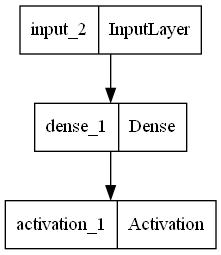

In [35]:
keras.utils.plot_model(model, "my_first_model.png")

In [22]:
roundeddata = (roundeddata-roundeddata.mean())/roundeddata.std()
roundedtarget = (roundedtarget-roundedtarget.mean())/roundedtarget.std()

In [23]:
roundeddata

array([[-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ],
       [-0.1224281 , -0.11526724, -0.11526724, ..., -0.1224281 ,
        -0.11526724, -0.11526724],
       [ 0.19264949,  0.17116693,  0.14968436, ...,  1.95421963,
         2.00434561,  1.90409365],
       ...,
       [-0.07946297, -0.07946297, -0.07946297, ..., -0.05798041,
        -0.05798041, -0.06514126],
       [ 0.13536266,  0.15684522,  0.16400607, ...,  0.01362813,
        -0.00785443, -0.02933699],
       [-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ]])

In [24]:
predata = sklearn.preprocessing.normalize(data,norm="l1")
pretarget = sklearn.preprocessing.normalize(target,norm="l1")
predata

array([[0.        , 0.00727273, 0.00545455, ..., 0.00545455, 0.00181818,
        0.        ],
       [0.00313725, 0.00509804, 0.00509804, ..., 0.00352941, 0.00431373,
        0.0054902 ],
       [0.00104952, 0.00097187, 0.00090833, ..., 0.00683837, 0.00699839,
        0.00667835],
       ...,
       [0.00261684, 0.00261684, 0.0027395 , ..., 0.00380259, 0.00400703,
        0.00327105],
       [0.00532952, 0.00574837, 0.0058928 , ..., 0.00277308, 0.00235423,
        0.00194982],
       [0.00293255, 0.00293255, 0.00293255, ..., 0.00293255, 0.00293255,
        0.00293255]])

In [25]:
from sklearn.model_selection import train_test_split

# Separate the test data
x, x_test, y, y_test = train_test_split(predata, pretarget, test_size=0.15, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [26]:
x_train.shape

(116, 249)

In [27]:
y_train.shape

(116, 249)

In [28]:
# Train the model.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=50, restore_best_weights=True)
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=1500,
    validation_data=(x_val, y_val))

Epoch 1/1500
4/4 [==============================] - 0s 32ms/step - loss: 0.2454 - accuracy: 0.0000e+00 - val_loss: 0.2443 - val_accuracy: 0.0000e+00
Epoch 2/1500
4/4 [==============================] - 0s 6ms/step - loss: 0.2437 - accuracy: 0.0000e+00 - val_loss: 0.2426 - val_accuracy: 0.0000e+00
Epoch 3/1500
4/4 [==============================] - 0s 6ms/step - loss: 0.2420 - accuracy: 0.0000e+00 - val_loss: 0.2408 - val_accuracy: 0.0000e+00
Epoch 4/1500
4/4 [==============================] - 0s 6ms/step - loss: 0.2402 - accuracy: 0.0000e+00 - val_loss: 0.2390 - val_accuracy: 0.0000e+00
Epoch 5/1500
4/4 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.0000e+00 - val_loss: 0.2373 - val_accuracy: 0.0000e+00
Epoch 6/1500
4/4 [==============================] - 0s 7ms/step - loss: 0.2366 - accuracy: 0.0000e+00 - val_loss: 0.2355 - val_accuracy: 0.0000e+00
Epoch 7/1500
4/4 [==============================] - 0s 7ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - val_los

In [29]:
from matplotlib import pyplot as plt
def display_learning_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0,0].plot(history.history["loss"])
    axs[0,0].legend(["train", "test"], loc="upper right")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss")

    axs[0,1].plot(history.history["accuracy"])
    axs[0,1].legend(["train", "test"], loc="upper right")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Accuracy")

    axs[1,0].plot(history.history["val_loss"])
    axs[1,0].legend(["train", "test"], loc="upper right")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("val_loss")

    axs[1,1].plot(history.history["val_accuracy"])
    axs[1,1].legend(["train", "test"], loc="upper right")
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("val_Accuracy")
    plt.show()

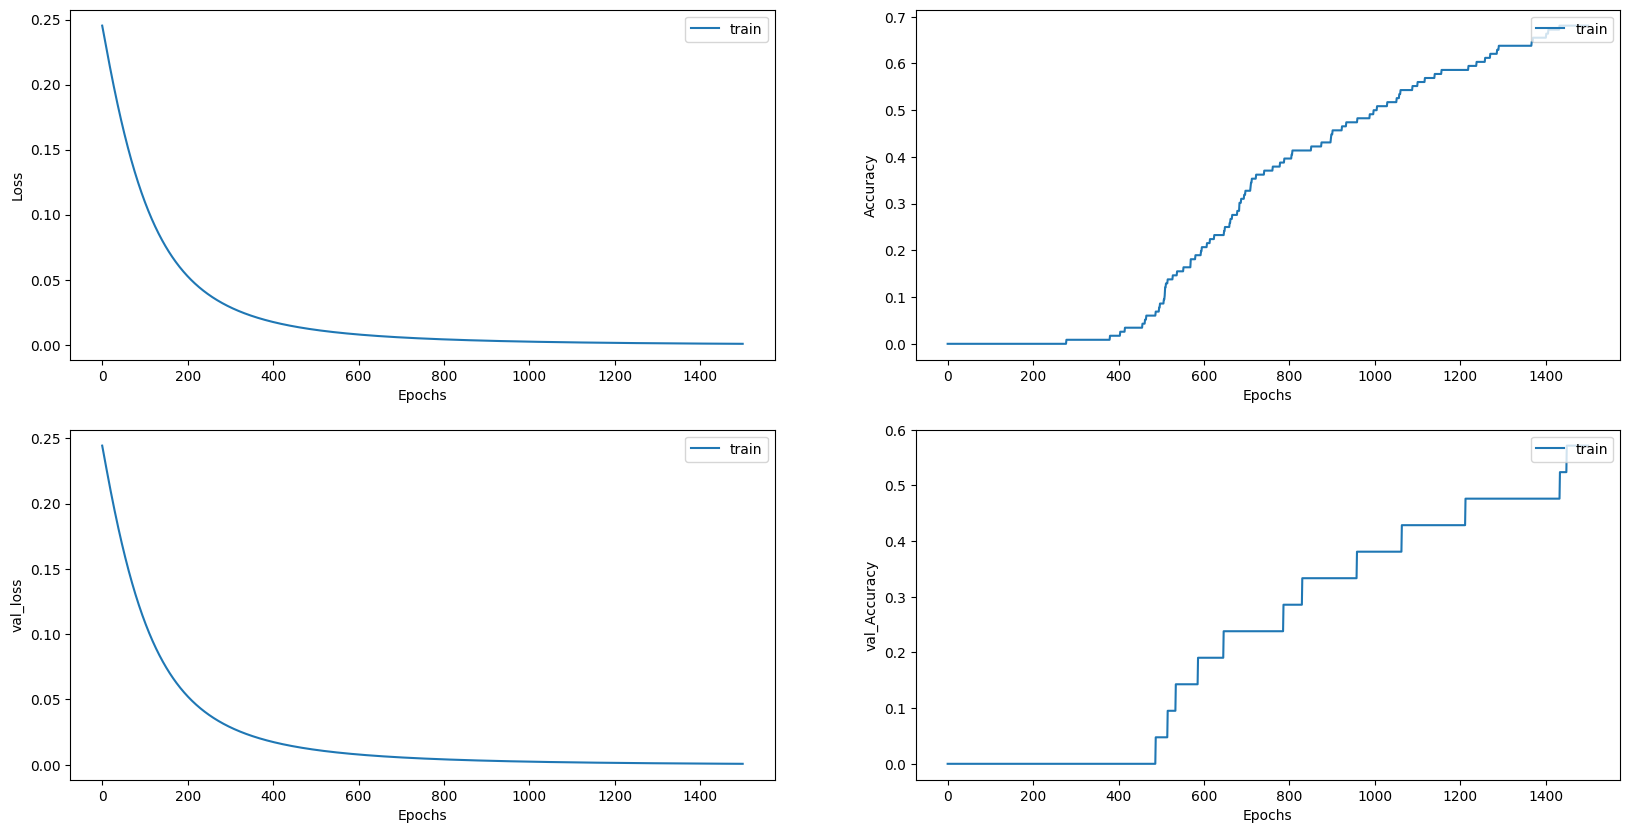

In [30]:
display_learning_curves(history)

In [31]:
%load_ext tensorboard

In [33]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Launching TensorBoard...

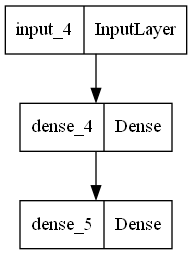

In [50]:
keras.utils.plot_model(model, "my_first_model.png")

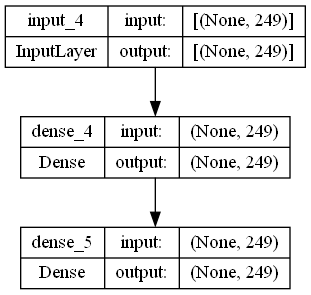

In [51]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [63]:
weights = model.get_weights()
weights

[array([[-0.02900123,  0.0627915 , -0.01941352, ..., -0.06776059,
          0.05426173,  0.00590248],
        [ 0.05714131,  0.0217549 , -0.09984891, ..., -0.08471114,
         -0.09510233,  0.00716283],
        [-0.09874404, -0.04953232, -0.09801145, ..., -0.09711359,
         -0.03696586, -0.1154447 ],
        ...,
        [-0.07325356, -0.04419072,  0.02104296, ...,  0.05587601,
         -0.02192408, -0.07082225],
        [-0.02962093, -0.07713024,  0.00340028, ...,  0.00076742,
         -0.07812869, -0.05735594],
        [ 0.04177393, -0.0132577 ,  0.06003856, ..., -0.02358534,
         -0.00974627, -0.11803873]], dtype=float32),
 array([-0.04373704, -0.04372924, -0.04300834, -0.00559949, -0.04368935,
        -0.04350935, -0.04371834, -0.12260058, -0.12514651, -0.04365931,
        -0.04368131, -0.0054314 , -0.04371263, -0.04314584, -0.00702265,
        -0.12560919, -0.04367572, -0.04328318, -0.00511542, -0.00596622,
        -0.00597911, -0.12949164, -0.04140043, -0.04366992, -0.043

In [ ]:
len(weights)